#### CIFAR10 Attack Notebook

In [1]:
%%capture installation
import os
import sys
import argparse
import datetime

import numpy as np

sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import yaml
from art.attacks.evasion import DeepFool, FastGradientMethod
from art.estimators.classification import PyTorchClassifier

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from typing import Callable, Tuple, Dict
from pathlib import Path
import pytorch_lightning as pl
from torch import nn

from dataloader import load_mnist
from models.autoencoder import (ANNAutoencoder, BaseAutoEncoder,
                                CelebAAutoencoder, CIFAR10Autoencoder)
from models.classifier import (CelebAClassifier, CIFAR10Classifier,
                                MNISTClassifier)

from attacks import ATTACK_MAPPINGS
from attacks.art_attack import execute_attack, get_models, get_xyz, hybridize
from attacks.plot_attack import plot_adversarial_images, plot_robust_accuracy
from dataloader import DATALOADER_MAPPINGS

In [2]:
class Args:
    batch_size = 10
    attack_name = "deepfool"
    device  = "mps"
    model_name = "cifar10_cnn_1"
    ae_name = "ann_128"
    plot = False
    plot_dir = "./plots"

args = Args()

In [3]:
attack_name = ATTACK_MAPPINGS.get(args.attack_name)
dataset_name = args.model_name.split("_")[0]
print(f"Working on the dataset: {dataset_name}!!!!!")

with open(f"./configs/{dataset_name}.yml", "r") as f:
    config = yaml.safe_load(f)

classifier_model, autoencoder_model, config = get_models(args)
print(f"Loaded classifier and autoencoder models in eval mode!!!!!")
_, _, test_dataloader = DATALOADER_MAPPINGS[config["dataset_name"]](batch_size=args.batch_size)
print(f"Loaded dataloader!!!!!") 

Working on the dataset: cifar10!!!!!


/Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded classifier and autoencoder models in eval mode!!!!!


100%|██████████| 170498071/170498071 [01:01<00:00, 2791169.84it/s]


Extracting /Users/swainsubrat/scratch/datasets/CIFAR10/cifar-10-python.tar.gz to /Users/swainsubrat/scratch/datasets/CIFAR10/
Files already downloaded and verified
Loaded dataloader!!!!!


In [4]:
x, y, z = get_xyz(args, autoencoder_model, test_dataloader)
    
config["latent_shape"] = args.ae_name.split('_')[-1]
classifier, hybrid_classifier, accuracy = hybridize(x, y, z, 
                                                    config, classifier_model, autoencoder_model)

# Perform attack
result: Dict = execute_attack(config, attack_name, x, y, z, classifier, hybrid_classifier, autoencoder_model)

/Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/image.so'
  Expected in: '/Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")
/Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empt

<class 'numpy.ndarray'> (10, 3, 32, 32)
Accuracy on benign test examples: 100.0%
(10, 256)
Accuracy on benign test examples(from reconstructed): 60.0%


DeepFool: 100%|██████████| 10/10 [01:39<00:00,  9.94s/it]


Accuracy on adversarial test examples: 20.0%


DeepFool: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


RuntimeError: Placeholder storage has not been allocated on MPS device!

In [33]:
orig_attk_images = result["DeepFool"]["x_test_adv_np"]
modf_attk_images = result["DeepFool"]["xx_test_adv_np"]
hybrid_attk_images = result["DeepFool"]["hybrid_x_np"]

orig_attk_noise = result["DeepFool"]["x_test_noise"]
modf_attk_noise = result["DeepFool"]["xx_test_noise"]
hybrid_attk_noise = result["DeepFool"]["hybrid_noise"]

import torchvision
def plot_images(images):
    plt.figure(figsize=(20, 2))
    images = torch.Tensor(images).reshape(-1, 3, 32, 32)
    # i = 1
    # for image in images:
    #     plt.subplot(5, 5, i, xticks=[], yticks=[])
    #     plt.imshow(np.transpose(image, (1, 2, 0)))
    #     i = i + 1

    #     if i == 26:
    #         break
    grid = torchvision.utils.make_grid(images, nrow=10, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

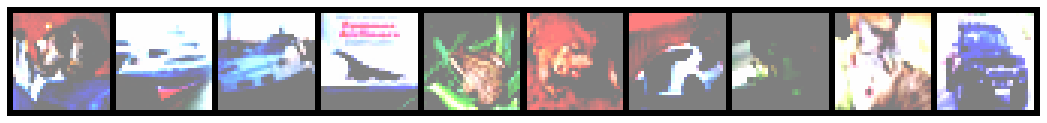

In [34]:
plot_images(orig_attk_images)

/home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


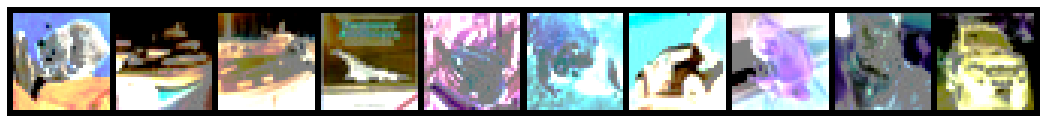

In [35]:
plot_images(orig_attk_noise)

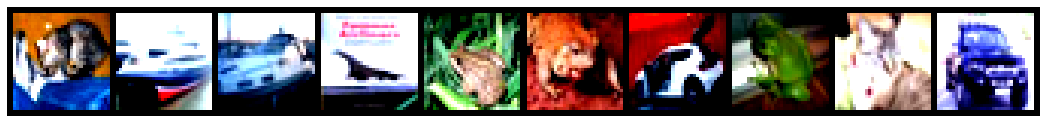

In [43]:
plot_images(x[1])

/home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


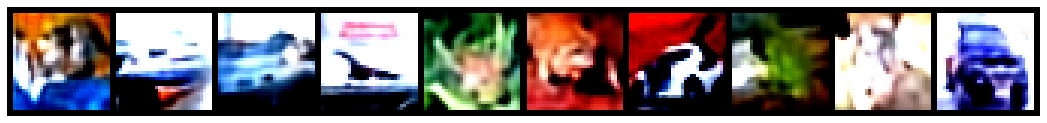

In [36]:
plot_images(modf_attk_images)

/home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


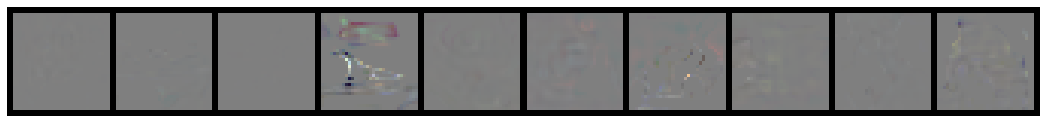

In [37]:
plot_images(modf_attk_noise)

##### LPIPS

In [53]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores

# LPIPS between original and original attacks
import torch
img0 = torch.Tensor(orig_attk_images) # image should be RGB, IMPORTANT: normalized to [-1,1]
img1 = x[0].detach().cpu()
d = loss_fn_alex(img0, img1)
print(d.flatten())

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
tensor([0.1225, 0.0824, 0.0768, 0.0555, 0.0994, 0.1637, 0.1594, 0.3517, 0.0549,
        0.0567], grad_fn=<ReshapeAliasBackward0>)


In [54]:
# LPIPS between original and modified attacks
import torch
img0 = torch.Tensor(modf_attk_images) # image should be RGB, IMPORTANT: normalized to [-1,1]
img1 = x[0].detach().cpu()
d = loss_fn_alex(img0, img1)
print(d.flatten())

tensor([0.0451, 0.0251, 0.0491, 0.0342, 0.0395, 0.0322, 0.0211, 0.0308, 0.0361,
        0.0281], grad_fn=<ReshapeAliasBackward0>)
